# Evaluate Results with Multiclass ROC Analysis

**Goal of this analysis:** Understand our best model's ability to distinguish between the different tumor classes, how the model handles some class imbalance, and generate visuals for threshold selection and comparison.


**1) Prepare Data:** Convert the multiclass labels into a binary format for analysis.

**2) Compute ROC and AUC:** Calculate ROC curves and AUC scores for each class using a One versus Rest strategy (OvR)

**3) Average AUC:** Compute btoh micro-averaged and macro-averaged AUC scores to evaluate overall model performance.

**4) Plotting Curves:** Plot the ROC curves for each class and the averaged ROC curves to visualize the model's performance.

**5) Validate Results**: Incorporate checks of the model outputs, calibration curves, and probability distributions to assess integrity of analysis.

## Importing Libraries

In [1]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.1 MB/s eta 0:00:00


In [23]:
#importing all libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
import pandas as pd
import tensorflow as tf
import numpy as np
import hashlib
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.calibration import calibration_curve

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import RocCurveDisplay

from sklearn.utils import shuffle

import shap

from shap import GradientExplainer

## Load in Test Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!pip uninstall -y tensorflow
#!pip install tensorflow==2.15
print(tf.__version__) # should be 2.15.0

2.15.0


In [5]:
# Change directory to 'DATASCI207_FinalProject'
os.chdir('/content/drive/My Drive/DATASCI207_FinalProject')
tf.keras.backend.clear_session()

In [6]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

In [7]:
X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

In [8]:
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

# Load each Model:

In [9]:
# Load the baseline model:
baseline_model = tf.keras.models.load_model("baseline_model_fit.keras")

In [10]:
# Load the 2-layer CNN model:
model_2_layers = tf.keras.models.load_model("model_2_layers.keras")

In [11]:
# Load the 3-layer CNN model:
model_3_layers = tf.keras.models.load_model("model_3_layers.keras")

In [12]:
# Load the hybrid CNN-Transformer model:
hybrid_transformer_cnn_model = tf.keras.models.load_model("hybrid_transformer_cnn_model.keras")

# One-versus-Rest Classification
In order to measure the effectiveness of each model for each class of tumor, we will run a One-vs-Rest (OvR) classification to generate ROC curves and AUC scores.

In [15]:
# convert y-test to binary format for computation
n_classes = Y_test.max() + 1
Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3])

## Generate ROC Curves, AUC Scores, and Confusion Matrix for each Model:

In [16]:
# Set class names
class_names = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary']

In [24]:
def evaluate_model(model, X_test, Y_test, class_names):
    model_dict = {baseline_model: 'Baseline',
                  model_2_layers: '2-Layer CNN',
                  model_3_layers: '3-Layer CNN',
                  hybrid_transformer_cnn_model: 'Hybrid CNN-Transformer'}

    # Determine the model name based on the dictionary key
    model_name = model
    model_key = model_dict[model_name]

    print(f"Evaluating Model: {model_key}\n")

    # Binarize the output labels
    Y_test_bin = label_binarize(Y_test, classes=np.arange(len(class_names)))
    n_classes = len(class_names)

    # Predict probabilities
    Y_test_pred = model.predict(X_test)

    # Compute ROC AUC for each tumor class
    fpr, tpr, aucs = {}, {}, {}
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_test_pred[:, i])
        aucs[i] = auc(fpr[i], tpr[i])

    # Compute micro and macro average AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_test_pred.ravel())
    aucs["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    aucs["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {aucs["micro"]:.2f})')
    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (area = {aucs["macro"]:.2f})', linestyle='--')

    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_name} (area = {aucs[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random guess (area = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_key}')
    plt.legend(loc="lower right")
    plt.show()

    # Generate confusion matrix
    Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)
    conf_matrix = confusion_matrix(Y_test, Y_test_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix: {model_key}')
    plt.show()

    # Generate classification report for analysis
    report = classification_report(Y_test, Y_test_pred_classes, target_names=class_names)
    print(f"Classification Report: {model_key}\n", report)

    # Additional Print Statements for Validation
    print("\nAdditional Validation Metrics:")
    print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred_classes):.4f}")
    print(f"Precision (macro): {precision_score(Y_test, Y_test_pred_classes, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(Y_test, Y_test_pred_classes, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(Y_test, Y_test_pred_classes, average='macro'):.4f}")

    # Update class_name labels
    for i, class_name in enumerate(class_names):
        print(f"AUC for class {class_name}: {aucs[i]:.4f}")

    print(f"Micro-average AUC: {aucs['micro']:.4f}")
    print(f"Macro-average AUC: {aucs['macro']:.4f}")

    # Check Predictions Distribution
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        plt.hist(Y_test_pred[:, i], bins=50, alpha=0.5, label=class_names[i])
    plt.legend()
    plt.title('Distribution of Predicted Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

    # Ensure predicted probabilities sum to 1 (True if so)
    print("\nCheck if predicted probabilities sum to 1:")
    print(np.allclose(np.sum(Y_test_pred, axis=1), 1))

    # Print first 5 raw model outputs to assess probabilities
    print("\nFirst 5 raw model outputs:")
    print(model.predict(X_test)[:5])

    # Check model calibration curves behavior
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        prob_true, prob_pred = calibration_curve(Y_test_bin[:, i], Y_test_pred[:, i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=class_names[i])

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curves')
    plt.legend()
    plt.show()



## Visualizations for each Model:

### Baseline Model:

Evaluating Baseline Model:
Evaluating Model: Baseline

38/38 [==============================] - 1s 20ms/step


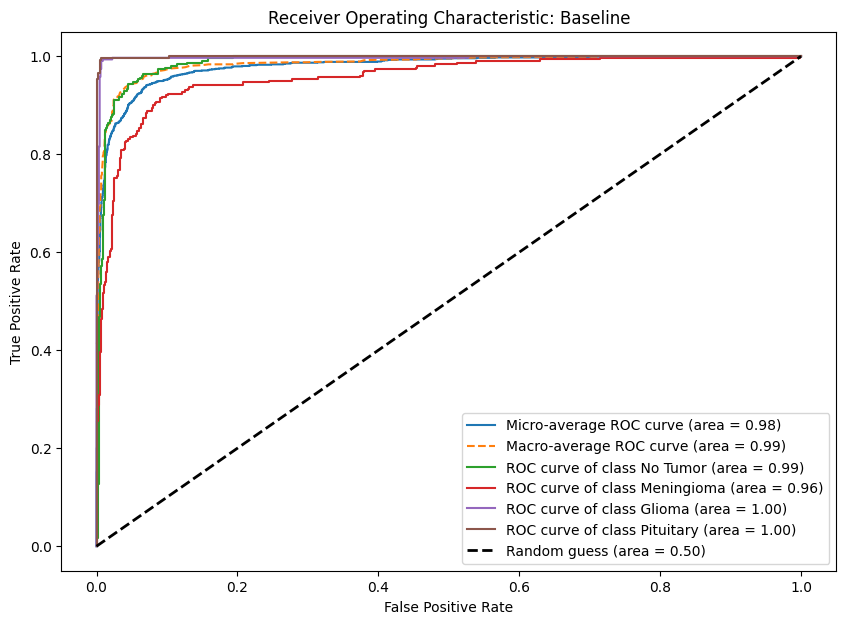

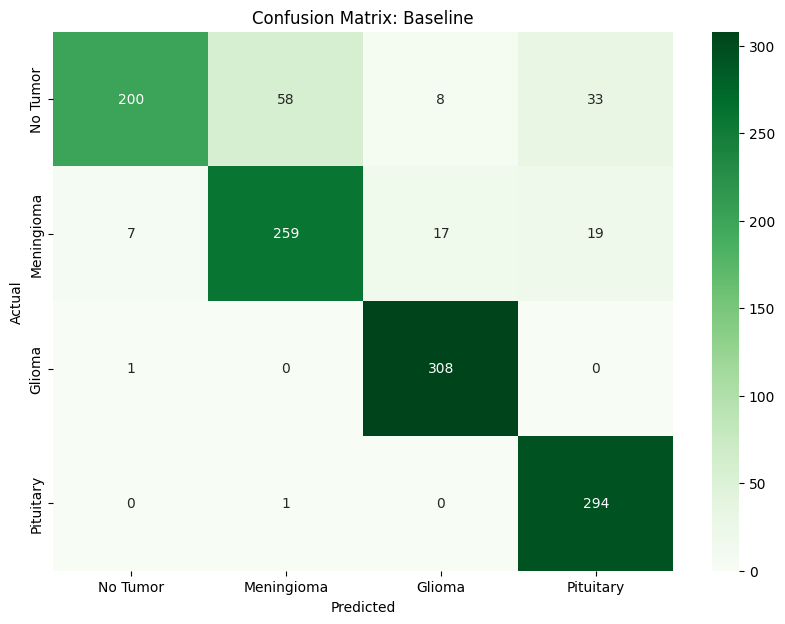

Classification Report: Baseline
               precision    recall  f1-score   support

    No Tumor       0.96      0.67      0.79       299
  Meningioma       0.81      0.86      0.84       302
      Glioma       0.92      1.00      0.96       309
   Pituitary       0.85      1.00      0.92       295

    accuracy                           0.88      1205
   macro avg       0.89      0.88      0.88      1205
weighted avg       0.89      0.88      0.88      1205


Additional Validation Metrics:
Accuracy: 0.8805
Precision (macro): 0.8877
Recall (macro): 0.8800
F1 Score (macro): 0.8753
AUC for class No Tumor: 0.9867
AUC for class Meningioma: 0.9558
AUC for class Glioma: 0.9967
AUC for class Pituitary: 0.9995
Micro-average AUC: 0.9796
Macro-average AUC: 0.9852


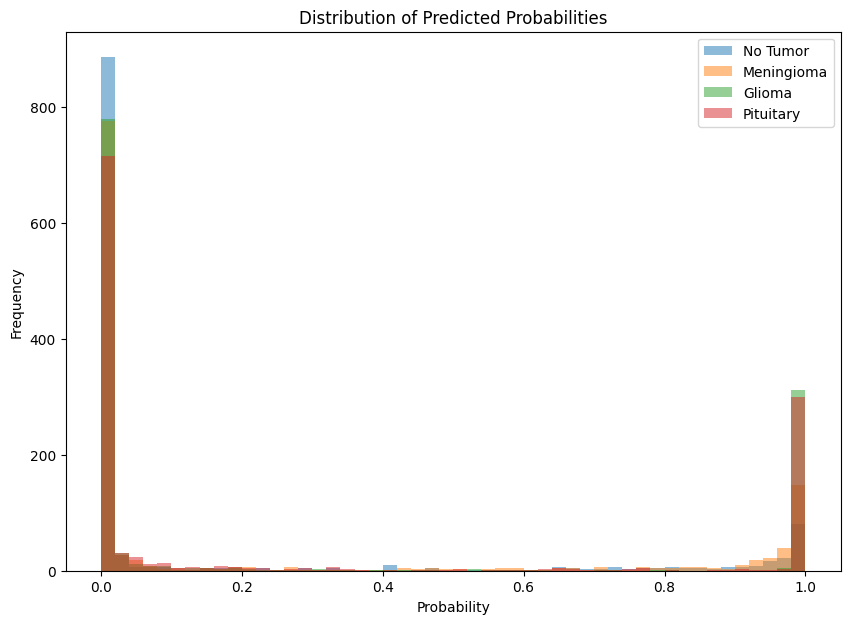


Check if predicted probabilities sum to 1:
True

First 5 raw model outputs:
38/38 [==============================] - 1s 19ms/step
[[1.2546839e-03 9.9870610e-01 3.9151237e-05 1.5650057e-08]
 [1.1573899e-04 7.7652377e-01 2.2334161e-01 1.8872262e-05]
 [2.7071526e-05 2.7056682e-01 4.4315597e-01 2.8625005e-01]
 [1.4423814e-09 9.9434882e-01 3.1335412e-03 2.5177437e-03]
 [7.7431288e-04 9.2867410e-01 7.0470601e-02 8.1020939e-05]]


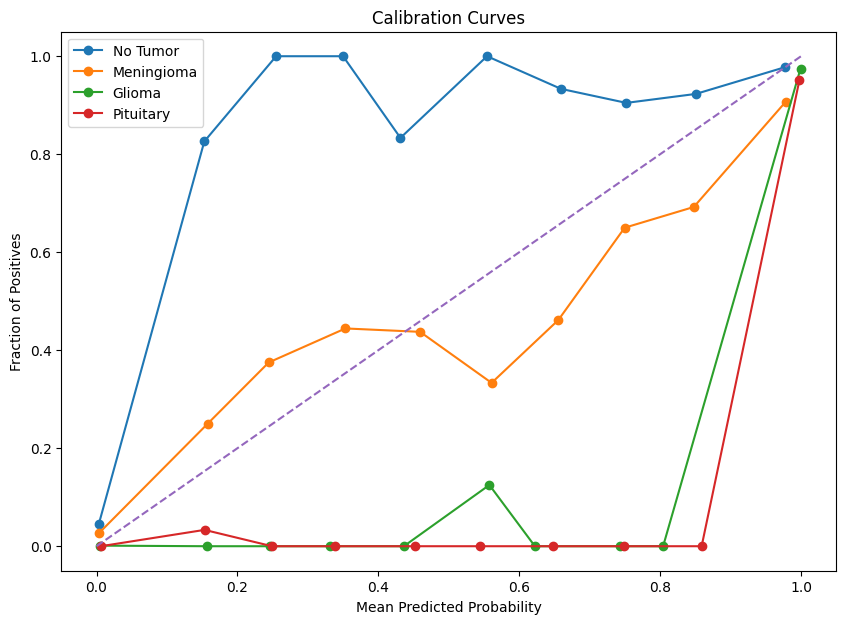

In [25]:
# Run evaluation function on baseline model:
print("Evaluating Baseline Model:")
evaluate_model(baseline_model, X_test, Y_test, class_names)


Evaluating 2-Layer CNN Model:
Evaluating Model: 2-Layer CNN

38/38 [==============================] - 1s 23ms/step


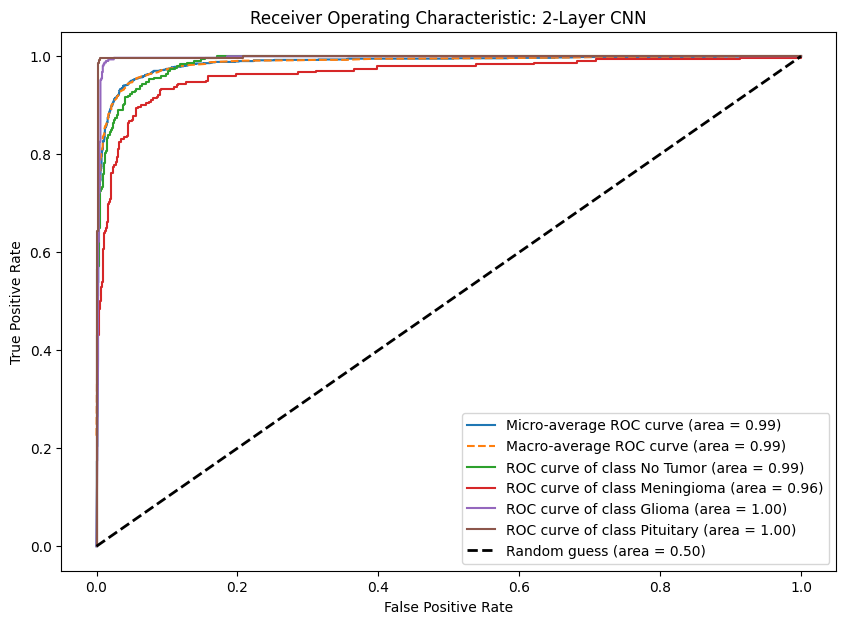

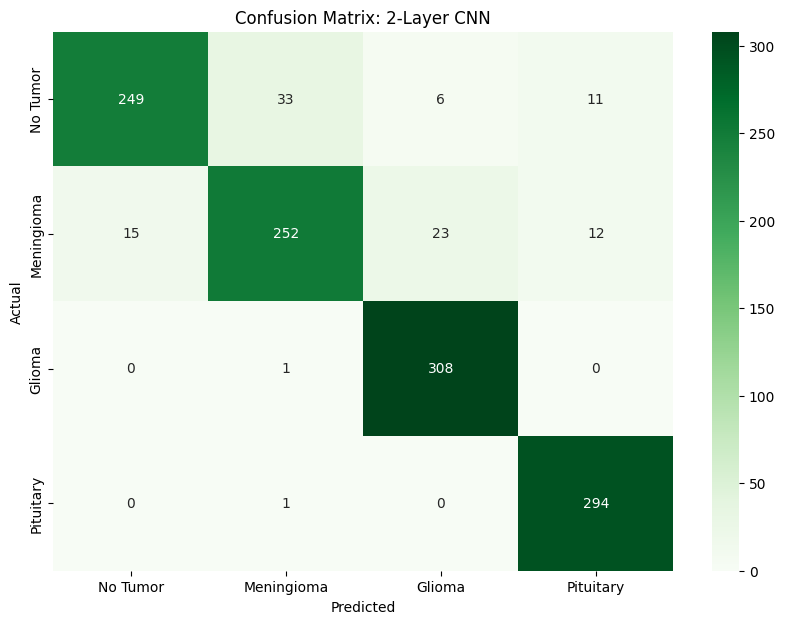

Classification Report: 2-Layer CNN
               precision    recall  f1-score   support

    No Tumor       0.94      0.83      0.88       299
  Meningioma       0.88      0.83      0.86       302
      Glioma       0.91      1.00      0.95       309
   Pituitary       0.93      1.00      0.96       295

    accuracy                           0.92      1205
   macro avg       0.92      0.92      0.91      1205
weighted avg       0.92      0.92      0.91      1205


Additional Validation Metrics:
Accuracy: 0.9154
Precision (macro): 0.9157
Recall (macro): 0.9151
F1 Score (macro): 0.9136
AUC for class No Tumor: 0.9879
AUC for class Meningioma: 0.9629
AUC for class Glioma: 0.9965
AUC for class Pituitary: 0.9979
Micro-average AUC: 0.9864
Macro-average AUC: 0.9869


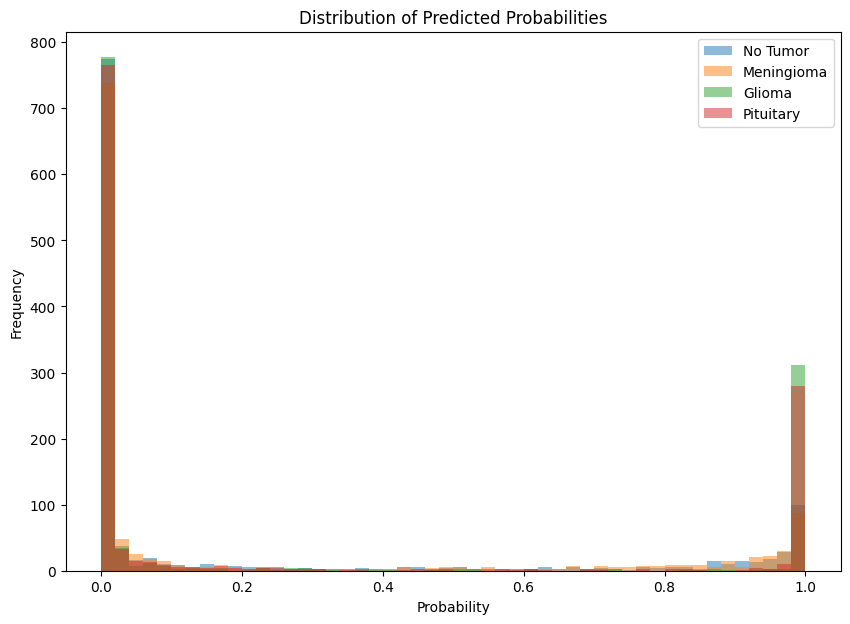


Check if predicted probabilities sum to 1:
True

First 5 raw model outputs:
38/38 [==============================] - 1s 23ms/step
[[3.7659626e-03 9.9539870e-01 8.3348632e-04 1.8965898e-06]
 [1.3771985e-02 7.8203440e-01 2.0398492e-01 2.0862982e-04]
 [6.5376727e-05 3.1053085e-02 2.8636730e-01 6.8251413e-01]
 [1.1983330e-07 9.8051435e-01 1.9200953e-02 2.8463453e-04]
 [2.4646902e-04 7.2144854e-01 2.7820337e-01 1.0157030e-04]]


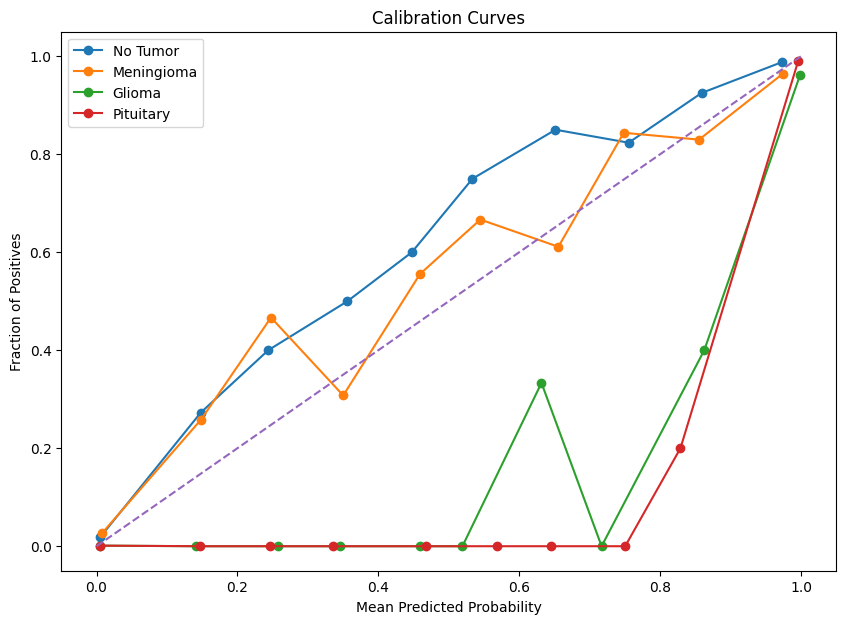

In [26]:
# Run evaluation function on 2-Layer CNN model:
print("\nEvaluating 2-Layer CNN Model:")
evaluate_model(model_2_layers, X_test, Y_test, class_names)


Evaluating 3-Layer CNN Model:
Evaluating Model: 3-Layer CNN

38/38 [==============================] - 1s 25ms/step


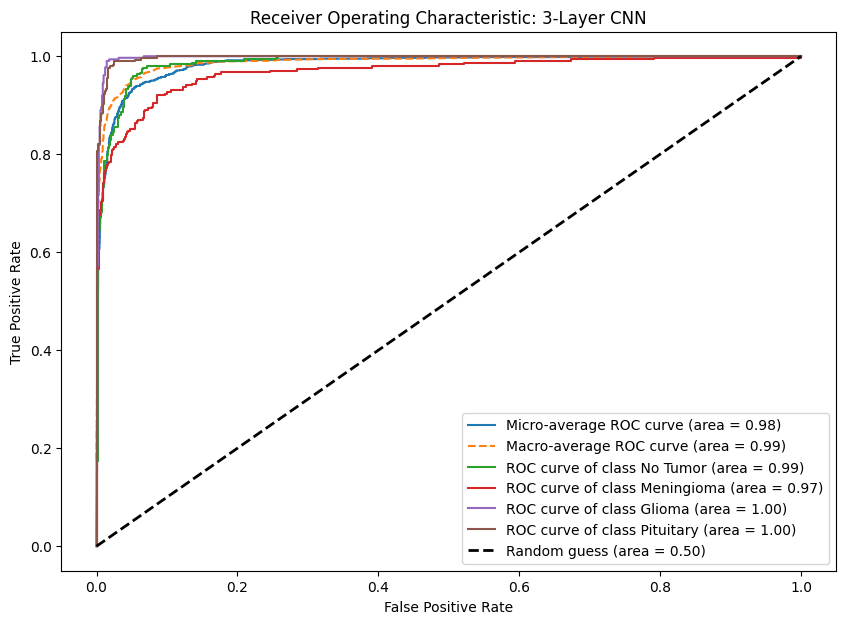

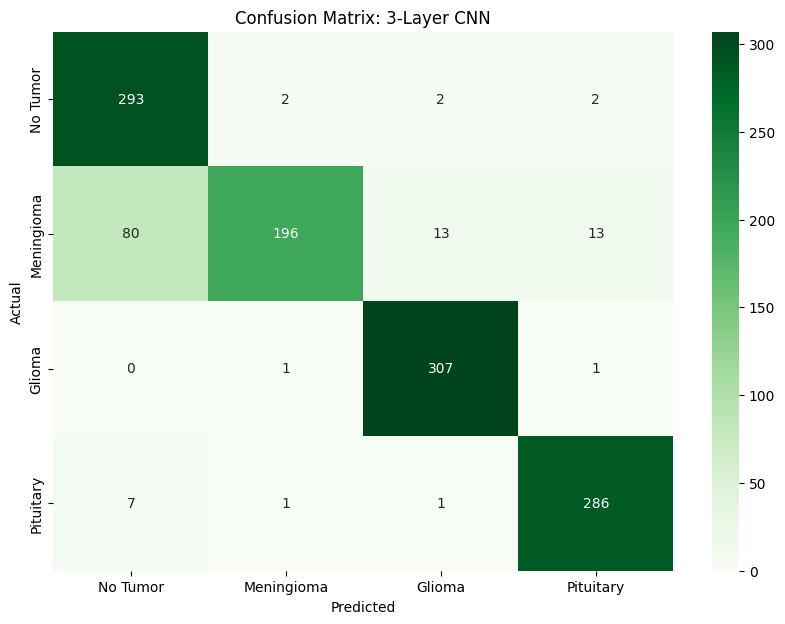

Classification Report: 3-Layer CNN
               precision    recall  f1-score   support

    No Tumor       0.77      0.98      0.86       299
  Meningioma       0.98      0.65      0.78       302
      Glioma       0.95      0.99      0.97       309
   Pituitary       0.95      0.97      0.96       295

    accuracy                           0.90      1205
   macro avg       0.91      0.90      0.89      1205
weighted avg       0.91      0.90      0.89      1205


Additional Validation Metrics:
Accuracy: 0.8979
Precision (macro): 0.9121
Recall (macro): 0.8980
F1 Score (macro): 0.8934
AUC for class No Tumor: 0.9873
AUC for class Meningioma: 0.9676
AUC for class Glioma: 0.9971
AUC for class Pituitary: 0.9967
Micro-average AUC: 0.9840
Macro-average AUC: 0.9877


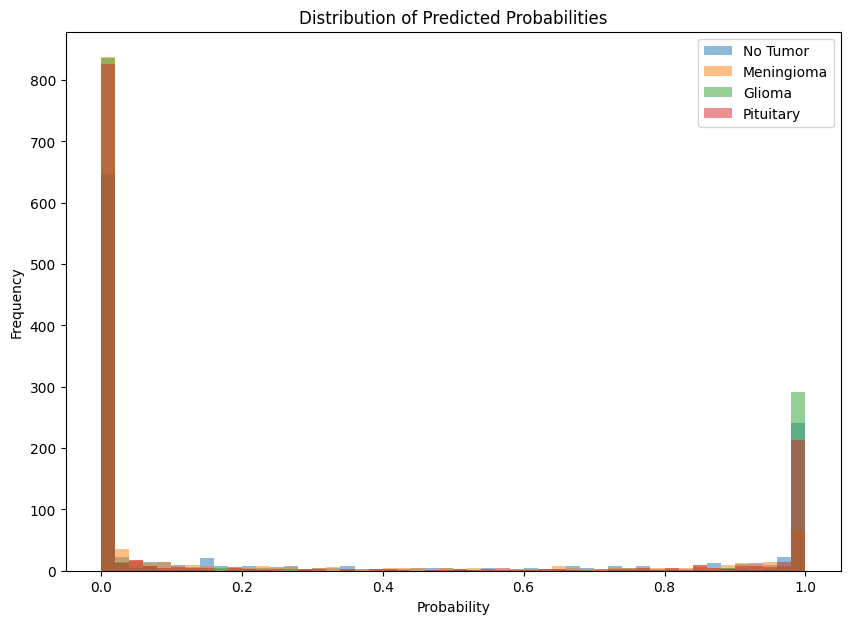


Check if predicted probabilities sum to 1:
True

First 5 raw model outputs:
38/38 [==============================] - 1s 24ms/step
[[2.50516713e-01 7.49468625e-01 1.42153685e-05 3.48518256e-07]
 [5.92870831e-01 1.85782596e-01 1.58582360e-01 6.27642646e-02]
 [3.62398394e-04 5.86893976e-01 2.69340491e-03 4.10050273e-01]
 [3.11995291e-06 9.98970270e-01 9.36902245e-04 8.96349375e-05]
 [7.53810629e-02 9.04055774e-01 2.05629077e-02 4.52335513e-07]]


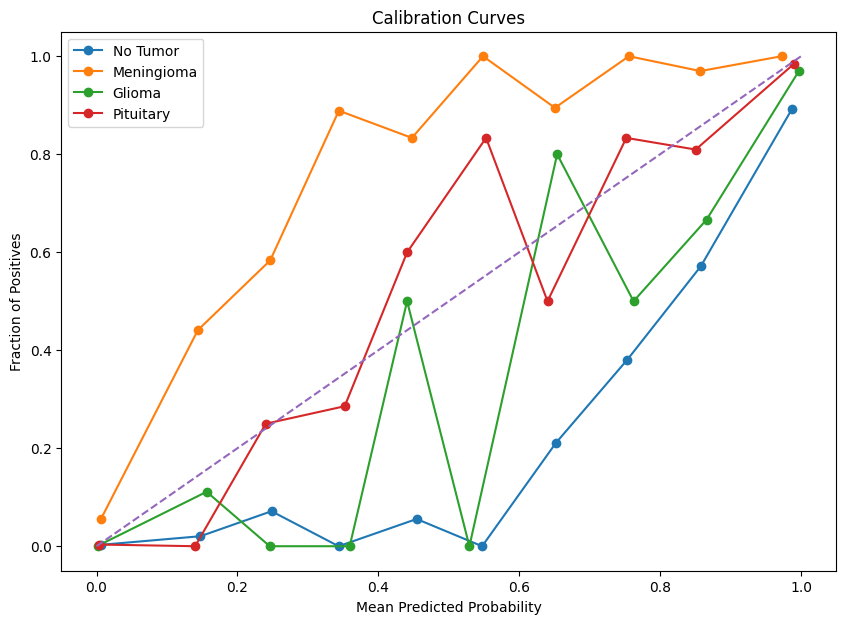

In [27]:
# Run evaluation function on 3-Layer CNN model:
print("\nEvaluating 3-Layer CNN Model:")
evaluate_model(model_3_layers, X_test, Y_test, class_names)


Evaluating Hybrid Model:
Evaluating Model: Hybrid CNN-Transformer

38/38 [==============================] - 12s 301ms/step


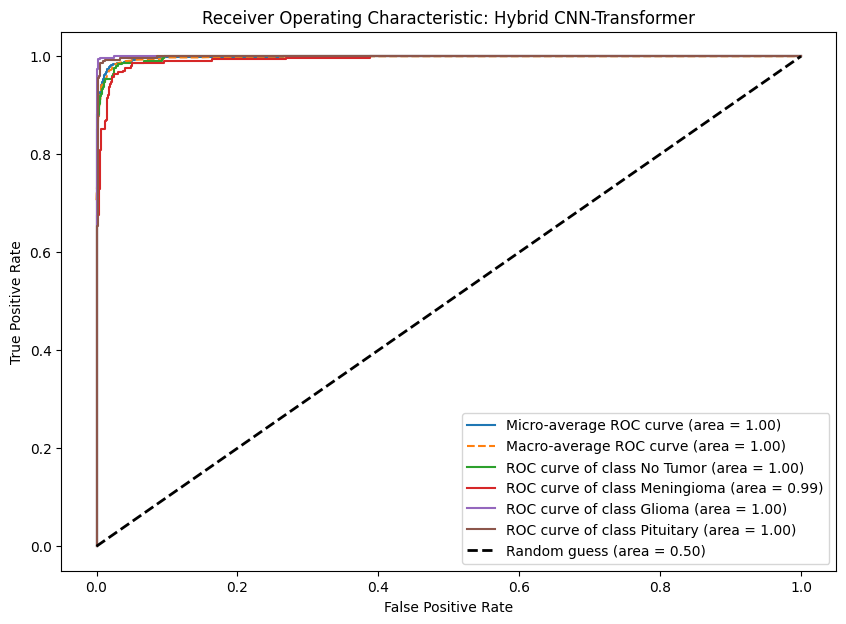

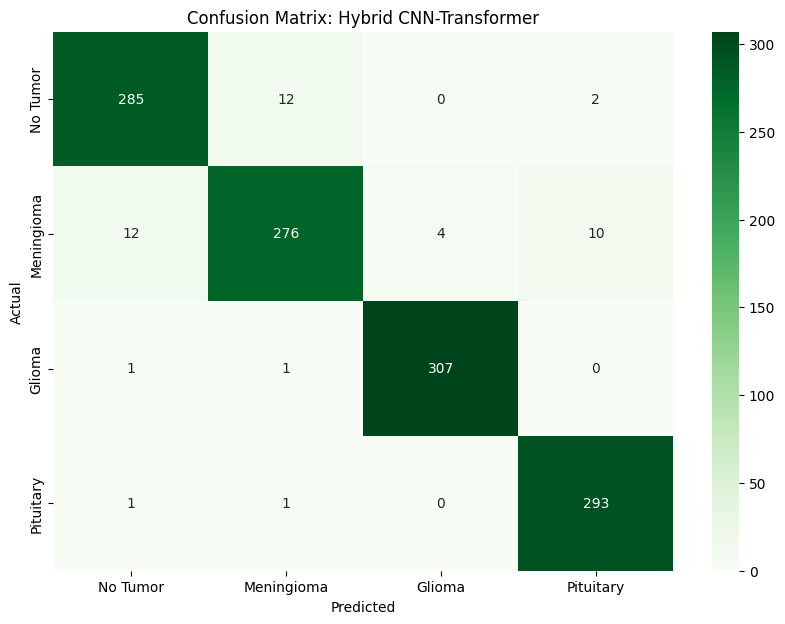

Classification Report: Hybrid CNN-Transformer
               precision    recall  f1-score   support

    No Tumor       0.95      0.95      0.95       299
  Meningioma       0.95      0.91      0.93       302
      Glioma       0.99      0.99      0.99       309
   Pituitary       0.96      0.99      0.98       295

    accuracy                           0.96      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.96      0.96      0.96      1205


Additional Validation Metrics:
Accuracy: 0.9635
Precision (macro): 0.9632
Recall (macro): 0.9635
F1 Score (macro): 0.9631
AUC for class No Tumor: 0.9974
AUC for class Meningioma: 0.9931
AUC for class Glioma: 0.9998
AUC for class Pituitary: 0.9985
Micro-average AUC: 0.9977
Macro-average AUC: 0.9974


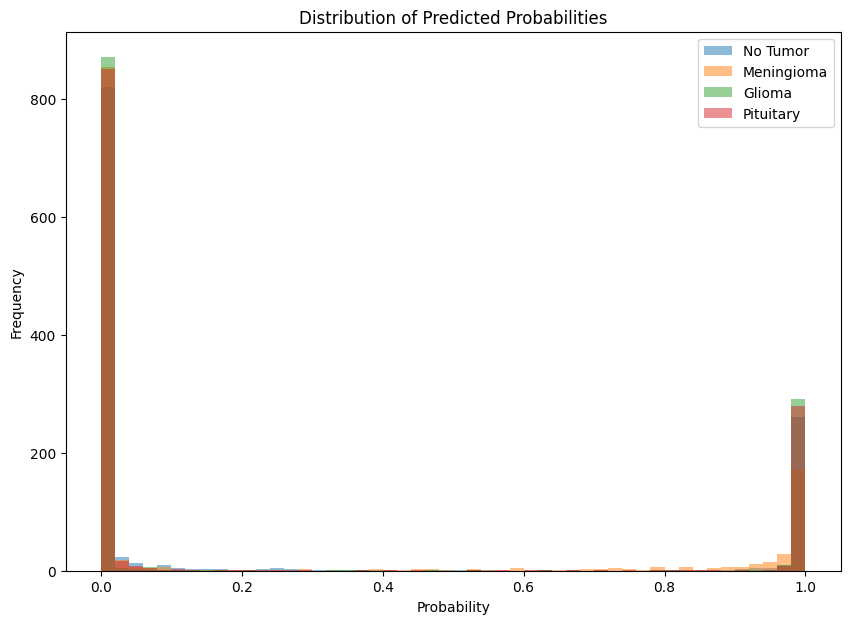


Check if predicted probabilities sum to 1:
True

First 5 raw model outputs:
38/38 [==============================] - 11s 290ms/step
[[2.3020040e-10 9.9999911e-01 4.5455115e-11 8.0642809e-07]
 [1.7065662e-01 8.2434553e-01 1.5084052e-03 3.4893251e-03]
 [5.6167725e-03 9.7849387e-01 1.1041512e-02 4.8478190e-03]
 [8.3013998e-05 9.9753225e-01 2.3815152e-03 3.2033770e-06]
 [5.7348971e-05 9.9991685e-01 8.4947533e-06 1.7243014e-05]]


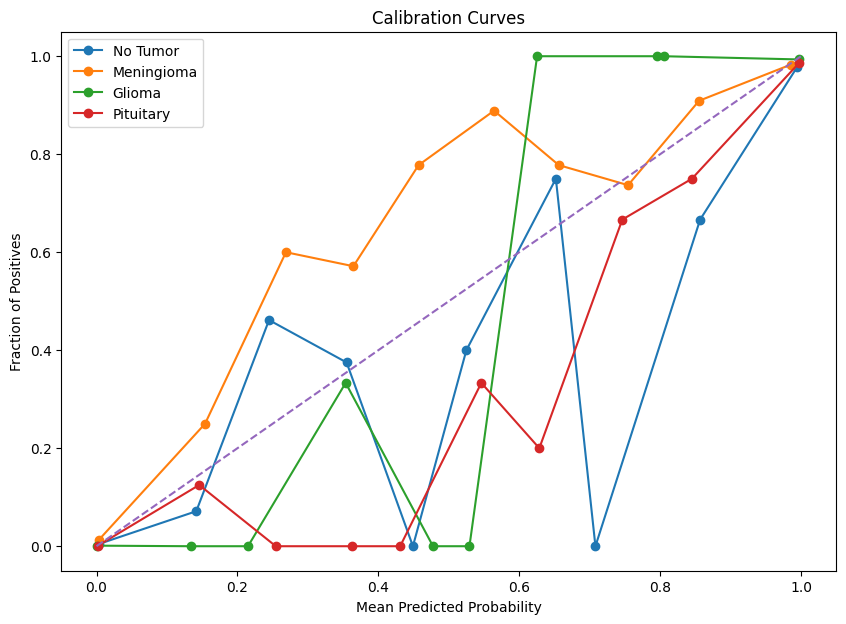

In [28]:
# Run evaluation function on Hybrid CNN-Transformer model:
print("\nEvaluating Hybrid Model:")
evaluate_model(hybrid_transformer_cnn_model, X_test, Y_test, class_names)

# SHAP Analysis
Although the hybrid model greatly improves the recall and F1 scores from our baseline model, we find that **Meningioma** is the class of tumor that confuses the most. We will use Shapley Additive Explanations (SHAP) to visualize why this is happening. SHAP is a package that allows for more explainability in ML models by visually representing the factors (in this case pixels) that are most associated with a given classification.

First, find instances where Meningioma is incorrectly classified in our Validation dataset:

In [32]:
# Obtain the model's predictions on the validation set
predictions = hybrid_transformer_cnn_model.predict(X_val)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Find the true labels
true_labels = Y_val

# Find the indices where predictions are incorrect
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Filter incorrect predictions for a specific class (e.g., Class 2)
specific_class = 1
incorrect_specific_class_indices = incorrect_indices[true_labels[incorrect_indices] == specific_class]

# Output the incorrect indices for the specific class
print(f"Indices of incorrect predictions for Class {specific_class}: (Meningioma)", incorrect_specific_class_indices)

44/44 [==============================] - 11s 247ms/step
Indices of incorrect predictions for Class 1: (Meningioma) [  27   51   64  102  159  169  196  205  213  330  348  361  403  409
  491  524  612  638  640  647  695  708  716  820  828  897  913  943
  944 1016 1056 1073 1149 1194 1257 1324 1338 1352]


In [33]:
# Define the explainer:
explainer = shap.GradientExplainer(hybrid_transformer_cnn_model, X_train)

In [34]:
# Choose image to display:
img_idx = 27

# we explain the model's predictions on the validation image at index==img_idx
shap_values = explainer.shap_values(X_val[img_idx:img_idx+1])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


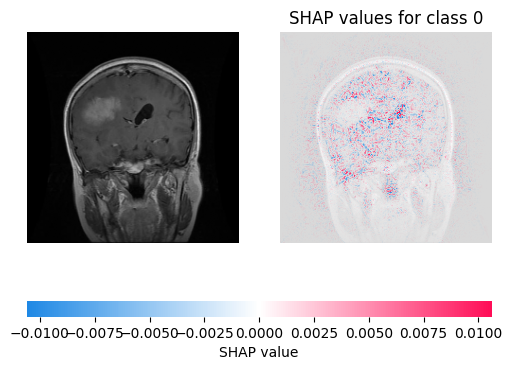

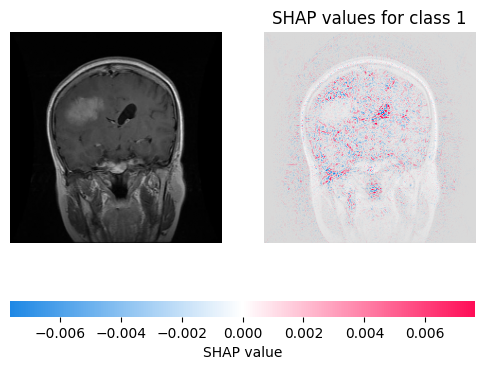

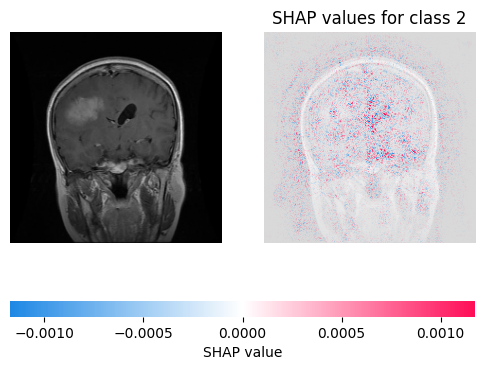

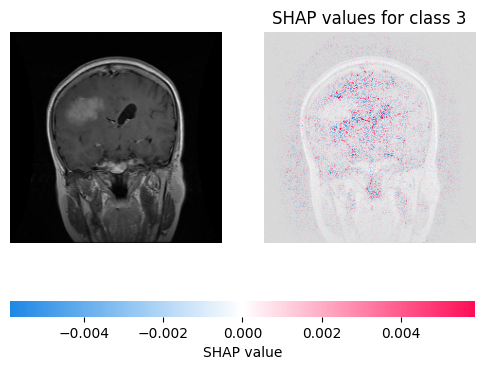

In [35]:
for i in range(4):  # Loop over each class
    shap_values_class_i = shap_values[0, :, :, :, i]  # Extract SHAP values for class i

    # Plot for the current class
    shap.image_plot(
        [shap_values_class_i],
        np.squeeze(X_val[img_idx]),
        show=False,

    )
    plt.title(f'SHAP values for class {i}')
    plt.show()

In the example above, we find that the true label for this MRI is 'Meningioma,' but the model has made a prediction of 'Glioma.' By visualizing the SHAP values, we see that the pixels/patterns in the MRI that are most strongly associated with 'Menangioma' are very similar to those associated with 'Glioma,' leading to an incorrect prediction. Future efforts to minimize this problem could be made by including more data points for training so that the model can develop more distinct features for each class.